# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.metrics import classification_report_imbalanced
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

# Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('LoanStats_2019Q1.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [5]:
# convert string values to integer
le = LabelEncoder()
df1 = df.copy()
df1["loan_status"] = le.fit_transform(df1["loan_status"])
df1["home_ownership"] = le.fit_transform(df1["home_ownership"])
df1["verification_status"] = le.fit_transform(df1["verification_status"])
df1["pymnt_plan"] = le.fit_transform(df1["pymnt_plan"])
df1["application_type"] = le.fit_transform(df1["application_type"])
df1["initial_list_status"] = le.fit_transform(df1["initial_list_status"])
df1["debt_settlement_flag"] = le.fit_transform(df1["debt_settlement_flag"])
df1["hardship_flag"] = le.fit_transform(df1["hardship_flag"])









# Create our features
X = df1.copy()
X = X.drop("loan_status", axis=1)


# # Create our target
y = df1["loan_status"]
y


0        1
1        1
2        1
3        1
4        1
        ..
68812    1
68813    1
68814    1
68815    1
68816    1
Name: loan_status, Length: 68817, dtype: int32

In [6]:
X.dtypes
X = X.select_dtypes(exclude=['object'])


In [7]:
# Check the balance of our target values
y.value_counts()
### target class "1" is low risk

1    68470
0      347
Name: loan_status, dtype: int64

In [8]:
# create testing and training datasets

X_train, X_test, y_train, y_test = train_test_split(X,
   y, random_state=1, stratify=y)

In [23]:
# initiate the RandomForest classifier
BRFC = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
BRFC_fit = BRFC.fit(X_train, y_train)
y_pred_BRFC = BRFC_fit.predict(X_test)
sorted(zip(BRFC_fit.feature_importances_, X.columns), reverse=True)

[(0.07459312344752933, 'last_pymnt_amnt'),
 (0.060305617315622395, 'total_pymnt_inv'),
 (0.059452890783571764, 'total_rec_prncp'),
 (0.05878931054778076, 'total_rec_int'),
 (0.0497612455841823, 'total_pymnt'),
 (0.031447283998453424, 'int_rate'),
 (0.020445705008863134, 'installment'),
 (0.02000170642513856, 'mths_since_recent_inq'),
 (0.0198569931279076, 'mo_sin_old_rev_tl_op'),
 (0.0194124950001158, 'dti'),
 (0.018019992461963924, 'annual_inc'),
 (0.01753264350675151, 'avg_cur_bal'),
 (0.017315120963427022, 'il_util'),
 (0.015981309545506583, 'max_bal_bc'),
 (0.0157382490063766, 'all_util'),
 (0.015295106443875646, 'bc_open_to_buy'),
 (0.01526772878014123, 'out_prncp_inv'),
 (0.015195553997750556, 'mths_since_rcnt_il'),
 (0.014460696471112356, 'revol_bal'),
 (0.014453328063291535, 'total_rev_hi_lim'),
 (0.014299388618028139, 'total_bc_limit'),
 (0.014229498336598242, 'tot_cur_bal'),
 (0.014187114155102787, 'total_bal_il'),
 (0.013887302581366095, 'total_bal_ex_mort'),
 (0.01373020297

In [15]:
balanced_accuracy_score(y_test, y_pred_BRFC)

0.7085725451329715

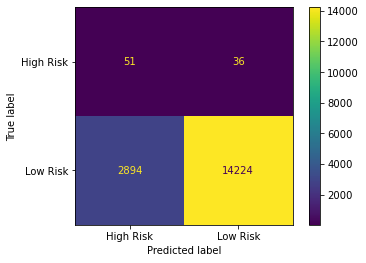

In [16]:
cm4 = confusion_matrix(y_test, y_pred_BRFC)
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=["High Risk", "Low Risk"])
disp4.plot()

In [17]:
CRI_BRFC = (classification_report_imbalanced(y_test, y_pred_BRFC, target_names=["High Risk", "Low Risk"]))
print(CRI_BRFC)

                   pre       rec       spe        f1       geo       iba       sup

  High Risk       0.02      0.59      0.83      0.03      0.70      0.48        87
   Low Risk       1.00      0.83      0.59      0.91      0.70      0.50     17118

avg / total       0.99      0.83      0.59      0.90      0.70      0.50     17205



In [27]:
# Easy Ensemble Classifier
EEC = EasyEnsembleClassifier(n_estimators=100, random_state=1)
EEC_fit = EEC.fit(X_train, y_train)
y_pred_EEC = EEC_fit.predict(X_test)


In [26]:
balanced_accuracy_score(y_test, y_pred_EEC)

0.7181178513442192

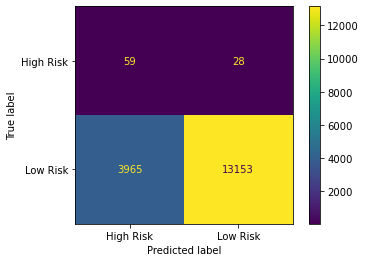

In [20]:
cm5 = confusion_matrix(y_test, y_pred_EEC)
disp5 = ConfusionMatrixDisplay(confusion_matrix=cm5, display_labels=["High Risk", "Low Risk"])
disp5.plot()

In [21]:
CRI_EEC = (classification_report_imbalanced(y_test, y_pred_EEC, target_names=["High Risk", "Low Risk"]))
print(CRI_EEC)

                   pre       rec       spe        f1       geo       iba       sup

  High Risk       0.01      0.68      0.77      0.03      0.72      0.52        87
   Low Risk       1.00      0.77      0.68      0.87      0.72      0.53     17118

avg / total       0.99      0.77      0.68      0.86      0.72      0.53     17205

